In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import scipy.stats as stats
import statsmodels.api as sm
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, adfuller, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf



# very good for ACF PACF : Interpreting ACF and PACF Plots for Time Series Forecasting
# https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c

In [128]:
df = pd.read_excel('2022_HiMCM_Data-B-co2.xlsx',sheet_name="origin(2)")
year = df['Year'].to_numpy()
ppm = df['PPM']
degree = df['Degree']


# df = pd.read_csv('shampoo.csv')
# year = df['Month'].to_numpy()
# # ppm = df['PPM']
# degree = df['Sales']

fig = go.Figure()
fig.add_traces(go.Scatter(x=year, y=degree.diff(2), mode = "lines", name = "Degree_diff(1)"))
# fig.add_traces(go.Scatter(x=year, y=degree, mode = "lines", name = "Degree"))

# fig.add_traces(go.Scatter(x=year, y=ppm.diff(1), mode = "lines", name = "ppm_diff(1)"))
# fig.add_traces(go.Scatter(x=year, y=degree, mode = "lines", name = "Degree"))

fig.update_layout( 
        title='Degree/Year (2-order differenced data)',
        title_x=0.5,
        # autosize=True,
        width=1000,
        height=500,
    )

fig.show()

In [129]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(degree.diff(1).dropna())
print('ADF Statistic: %f' % result[0])
print('1d -> p-value: %f' % result[1])



from numpy import log

print("\ndegree ")

result = adfuller(degree.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

result = adfuller(degree.diff(1).dropna())
print('ADF Statistic: %f' % result[0])
print('1d -> p-value: %f' % result[1])

print("\nppm ")

result = adfuller(ppm.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

result = adfuller(ppm.diff(2).dropna())
print('ADF Statistic: %f' % result[0])
print('1d -> p-value: %f' % result[1])

ADF Statistic: -5.270823
1d -> p-value: 0.000006

degree 
ADF Statistic: 0.894108
p-value: 0.993013
ADF Statistic: -5.270823
1d -> p-value: 0.000006

ppm 
ADF Statistic: 4.299152
p-value: 1.000000
ADF Statistic: 0.079494
1d -> p-value: 0.964633


In [130]:
from pmdarima.arima.utils import ndiffs

y = degree
# y = ppm


## Adf Test
print(ndiffs(y, test='adf'))  # 2

# KPSS test
print(ndiffs(y, test='kpss'))  # 0

# PP test:
print(ndiffs(y, test='pp'))  # 2

1
1
0


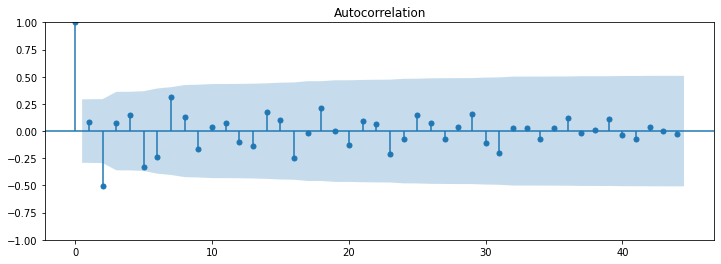

In [131]:
ddd = 2

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(111)
# ax2 = fig.add_subplot(312)
# ax3 = fig.add_subplot(313)


# plot_pacf(degree.diff(ddd).dropna(), method='ols', lags=(len(degree) - ddd - 1)/2 -1, ax=ax1)
# plot_pacf(degree.diff(ddd).dropna(),  method='ywm', lags=(len(degree) - ddd - 1)/2 -1, ax=ax1)

plot_acf(degree.diff(ddd).dropna(), lags=len(degree) - ddd - 1, ax=ax1)


plt.show()


# p = 2 or 1 or 6
# d = 1
# q = 0, 1



# 2,1,0
# 2,1,1
# 1,1,0
# 1,1,1
# 6,1,0
# 6,1,1

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   47
Model:                 ARIMA(2, 2, 1)   Log Likelihood                  35.467
Date:                Tue, 15 Nov 2022   AIC                            -62.935
Time:                        20:49:39   BIC                            -55.708
Sample:                             0   HQIC                           -60.241
                                 - 47                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4308      0.163     -2.640      0.008      -0.751      -0.111
ar.L2         -0.4174      0.160     -2.613      0.009      -0.730      -0.104
ma.L1         -0.9956      2.241     -0.444      0.6

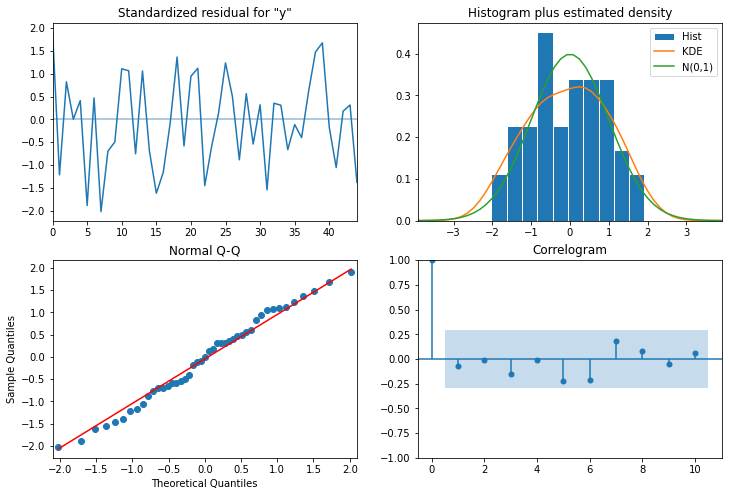

In [132]:
# 2,1,1 ARIMA Model (p,d,q)
modelfit = sm.tsa.ARIMA(degree.dropna().to_numpy(), order=(2,2,1)).fit()  # 默认使用最小二乘generalized least squares(GLS)，‘mle’是极大似然估计
print(modelfit.summary())
modelfit.plot_diagnostics(figsize=(12,8))
plt.show()


# 2,1,0
# 2,1,1
# 1,1,0
# 1,1,1
# 6,1,0
# 6,1,1

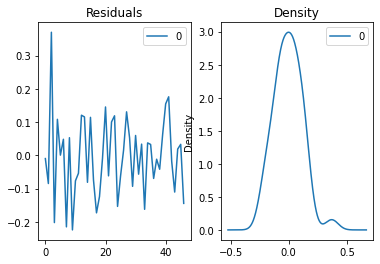

NormaltestResult(statistic=array([3.07037931]), pvalue=array([0.21541483]))

In [95]:
# Plot residual errors
residuals = pd.DataFrame(modelfit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()
stats.normaltest(residuals)

In [133]:
# # Actual vs Fitted
from statsmodels.graphics.tsaplots import plot_predict
# plot_predict(modelfit.get_prediction, dynamic=False)

modelfit_predict = sm.tsa.ARIMA(degree.dropna().to_numpy(), order=(2, 2, 1)).fit()
# print(mmodelfit_predict.summary())
forecast = modelfit_predict.predict(dynamic=False)

figp = go.Figure()
figp.add_traces(go.Scatter(x=year, y=degree, mode = "lines", name = "Actual"))
figp.add_traces(go.Scatter(x=year, y=forecast, mode = "lines", name = "Fitted"))

figp.update_layout( 
        title='Actual vs Fitted',
        title_x=0.5,
        autosize=False,
        width=1200,
        height=500,
    )

figp.show()


47
23


c:\Users\bzhu5\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\bzhu5\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\bzhu5\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



[0.45922935039781404, 0.5424840337564143, 0.49164237545108147, 0.5107044346845478, 0.4890129047684717, 0.5669513389698053, 0.6280402055342797, 0.6132057288879467, 0.6803540729924615, 0.6325572151218579, 0.7008672987183283, 0.6209908667036157, 0.6759334953786356, 0.6801060843665672, 0.6721356103106071, 0.7093414407939849, 0.6774976747841674, 0.7323648234458482, 0.8295577546063009, 0.948913982113986, 0.95706970566184, 0.9441133898463956, 0.9844677032937394, 0.9890009598059298]


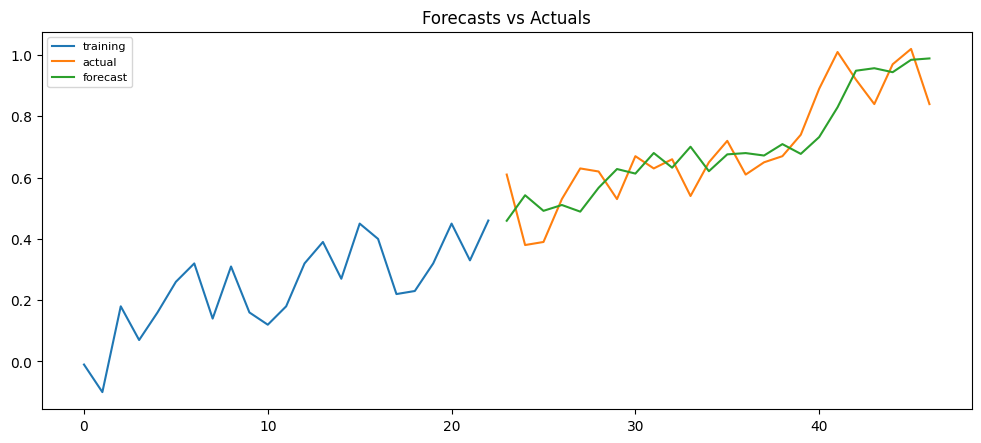

{'mape': 0.13057355493786327,
 'me': 0.0006892687664427702,
 'mae': 0.08264037869234725,
 'mpe': 0.020001649827387485,
 'rmse': 0.0987965753623105,
 'acf1': 0.014355234952163239,
 'corr': 0.8274333245352277,
 'minmax': 0.11615376654806375}

In [135]:
# https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

# from statsmodels.tsa.stattools import acf

# Create Training and Test -  split the data into train (80%) and test (20%).
train_len = int(len(degree)*0.50)
train = degree[:train_len]
test = degree[train_len:]


print(len(degree))
print(train_len)

history = [x for x in train]
predictions = list()


for t in range(len(test)):
    model = sm.tsa.ARIMA(history, order=(2,2,1))
    model_fit = model.fit()
    pred = model_fit.forecast(steps=1)
    yhat = pred[0]
    predictions.append(yhat)
    # Append test observation into overall record
    obs = test[t+train_len]
    history.append(obs)


print(predictions)


# Make as pandas series
fc_series = pd.Series(predictions, index=test.index)
# lower_series = pd.Series(conf[:, 0], index=test.index)
# upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series,
#                  color='k', alpha=.15)
plt.title('Forecasts vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(forecast-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(np.array(predictions), test.values)

In [136]:

# Build Model to train the values
# modelfit_future = sm.tsa.ARIMA(degree.dropna().to_numpy(), order=(2, 2, 4)).fit()
modelfit_future = sm.tsa.ARIMA(degree.dropna().to_numpy(), order=(2, 2, 1)).fit()

# 2,1,0
# 2,1,1
# 1,1,0
# 1,1,1
# 6,1,0
# 6,1,1

# print(modelfit_future.summary())


ystart = 1975
yend_true_data = 2021
yend = 2050

predict = modelfit_future.predict(start =0, end = yend_true_data - ystart, dynamic=False)

# print(type(predict))
print(len(predict))

# # Forecast year = 30
future_year = yend - yend_true_data + 1
forecast_year = modelfit_future.forecast(steps=future_year) 
# print(forecast_year)

predict = np.append(predict, forecast_year)

yearlong = np.linspace(ystart, yend-1,yend - ystart )

fig_future = go.Figure()
fig_future.add_traces(go.Scatter(x=yearlong[:yend_true_data-ystart+1], y=degree, name = "actual data"))
# fig_future.add_traces(go.Scatter(x=yearlong[yend_true_data-ystart+1:], y=forecast_year, name = "predict data"))
fig_future.add_traces(go.Scatter(x=yearlong, y=predict, name = "predict data"))


fig_future.update_layout(
        xaxis = dict(
            title = "Year"
        ),
        yaxis = dict(
            title = "Degree(Celcius)"
        ),
        title='Degree Increment with Years',
        title_x=0.5,
        autosize=True,
        width=1500,
        height=900,
    )
fig_future.show()




47


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-77.257, Time=0.50 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-61.733, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-64.487, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-62.626, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-70.692, Time=0.27 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-67.464, Time=0.48 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-65.156, Time=0.15 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 4.505 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   47
Model:               SA

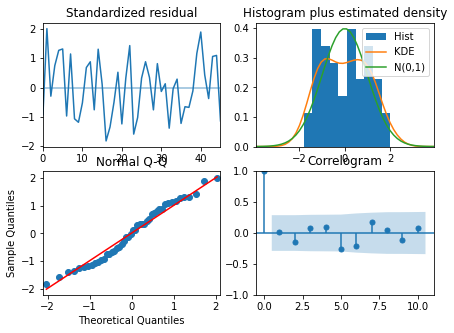

In [85]:
import pmdarima as pm


model = pm.auto_arima(degree, start_p=1, start_q=1,
                      test='adf',       # use adftest (adf) to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)


# model = pm.auto_arima(degree)


print(model.summary())

model.plot_diagnostics(figsize=(7,5))
plt.show()